<a href="https://colab.research.google.com/github/edwardhat/DataAI/blob/main/aria_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install transformers==4.18.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import re
import os

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "GroNLP/gpt2-small-italian"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name)

Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/959 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/427M [00:00<?, ?B/s]

In [20]:
OriginalModel = model
OriginalTokenizer = tokenizer

In [21]:
!git clone https://github.com/edwardhat/NLP.git
!mv /content/NLP/Dataset.zip /content
!rm -r /content/NLP
!unzip /content/Dataset.zip -d /content/dataset

Cloning into 'NLP'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 406.24 KiB | 3.83 MiB/s, done.
Archive:  /content/Dataset.zip
replace /content/dataset/a-forza-di-martelli.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [22]:
def remove_capital_lines(text):
    lines = text.split('\n')
    filtered_lines = [line for line in lines if not re.match(r'^[A-Z\s]+$', line)]
    filtered_text = '\n'.join(filtered_lines)
    return filtered_text

In [23]:
directory = '/content/dataset'

output_file = '/content/merged.txt'

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as infile:
            content = remove_capital_lines(infile.read())
            with open(output_file, 'a') as outfile:
                outfile.write(content)

In [24]:
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

class TextSet:
  def __init__(self, txt_path, tokenizer, batch_len=128):
    corpus_string = read_txt(txt_path)
    self.text_in_a_string = "".join(corpus_string).replace('\n', ' ')
    
    self.tokenizer = tokenizer
    self.tokenized_corpus = self.tokenizer(self.text_in_a_string)['input_ids']
    self.batch_len = batch_len
    
    self.tokenized_corpus = self.tokenized_corpus[:len(self.tokenized_corpus)//self.batch_len*self.batch_len]
    self.corpus_tensor = self._batchify_text()
    
  def _batchify_text(self):
    entire_corpus_tensor = torch.LongTensor(self.tokenized_corpus)
    return entire_corpus_tensor.reshape(-1, self.batch_len)
    
  def __len__(self):
    return len(self.corpus_tensor)

  def __getitem__(self, idx):
    return self.corpus_tensor[idx]

my_txt_path = "merged.txt"
train_set = TextSet(my_txt_path, tokenizer, batch_len=128)

train_set[0], train_set.tokenizer.decode(train_set[0])

(tensor([   48,  3416,    12,   382,   462,  1152,  1638,    12,  1791,   312,
          6630,   288,  2884,    27,  1111,   286,   823,  1693,   605,  4123,
            27, 13871,   311, 10905,  3925,   414,   265,    14, 12482,   389,
            12,   278,   892,   331,  2563,    12,   442,   262, 20955,  6648,
          1493,  6282,    27,   359,   615,  6774, 11216,  1090,   490,   349,
          9670,   390,    14, 10278,   823,  2558,    12, 25631, 11876,     1,
         16489,  1151,   456,  4383,   269,    14,   377, 11288,     9,     8,
          7148,   443,   567,  1147,  8825,  3537, 14386,    12, 14085,   498,
             1, 23947,     7,   424,   300,  3065,   285,     7,   282,  3923,
            12,   306, 16436,  1072,   262,   514,   706,    82,   695,   272,
         11017,    14,   564,   481,  4498,   297,   402,     7,   823,   350,
           298,  1777, 10402,    14,   717,  5021,   513,   262,  3680,   362,
           818,   272,  3065,  4174, 23070,    12,  

In [25]:
from torch.utils.data import DataLoader
train_set = TextSet(my_txt_path, tokenizer, batch_len=128)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

100%|██████████| 10/10 [11:50<00:00, 71.02s/it]


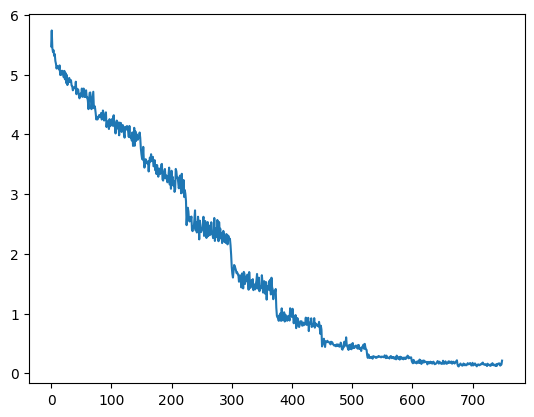

In [26]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_record = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
model.to(device)
for epoch in tqdm(range(num_epochs)):
  for batch in train_loader:
    out = model(batch.cuda()).logits
    out = torch.softmax(out, dim=-1)
    correct_next_word = batch[:, 1:]
    out_flatten = out[:, :-1, :].reshape(-1, out.shape[-1])
    correct_next_word = correct_next_word.reshape(-1)

    prob_of_correct_word = out_flatten[torch.arange(len(correct_next_word)), correct_next_word]

    loss = -torch.log(prob_of_correct_word+1e-6).mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())
    
plt.plot(loss_record)

In [29]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0, do_sample=True, early_stopping=True)

your_prompt = "Finalmente"
your_max_length = 100
your_num_sequences = 2

generator(your_prompt, max_length=your_max_length, num_return_sequences=your_num_sequences) 

[{'generated_text': "Finalmente fa scempio Ah nel regno dei cieli, E il figlio s'avvince a più possente meta... O figlia di Zefido ell' gonnellino di morte, Il turpe zingaro spirò!... Tale baldacchio è la mia Gloria, Abbandonar tornante! Chiusi in quel sorriso l'amarezza, Sarò per lui che lo può. (parte)Ben io t'invenni, o fatal scritto!... In"},
 {'generated_text': "Finalmente si trar saprò; fra tanti ver i nodi, e questa cor non è. Finchè quest'empia idea La mia scaramanzina scena sta, io lo so, se avrai tu ben qualche amante, Frescon ognun suo risponda, Or che gusta omai l'amor: Un dì sol scopri l'anima Don Alvaro Cara don Alvaro, sarai col tuo celeste tema; Ti guiderà l'amor nella calma In così motivi"}]

## - 데이터셋에 'Scene II', 'Aria No.5' 또는 캐릭터 이름 같은 noise 섞여있음 근데 이게 패턴이 있는게 아니라 거의 모든 데이터마다 다른 형태로 있어서 manually cleaning 해야할수도...? 그러면 결과 조금 더 괜찮아질듯